In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [18]:
# Calculate the date 1 year ago from the last data point in the database
Last_date = session.query(Measure.date).order_by(Measure.date.desc()).first()

Last_date_fmt = dt.datetime.strptime(Last_date[0], "%Y-%m-%d")
year = Last_date_fmt.year
month = Last_date_fmt.month
day = Last_date_fmt.day
print(year,month,day)

2017 8 23


In [19]:
# Calculate the date 1 year ago from the last data point in the database
Year_ago_date = dt.date(year,month,day) - dt.timedelta(days=365)
print("Year ago Date: ", Year_ago_date)

Year ago Date:  2016-08-23


In [15]:
# Perform a query to retrieve the date and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

Precp_data = session.query(Measure.date, Measure.prcp).filter(Measure.date >= Year_ago_date).all()
precp_data_df = pd.DataFrame(Precp_data, columns = ['Date', 'Precipitation'])
precp_data_df = precp_data_df.dropna(how='any')
precp_data_df = precp_data_df.set_index('Date').sort_values(by='Date')
precp_data_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


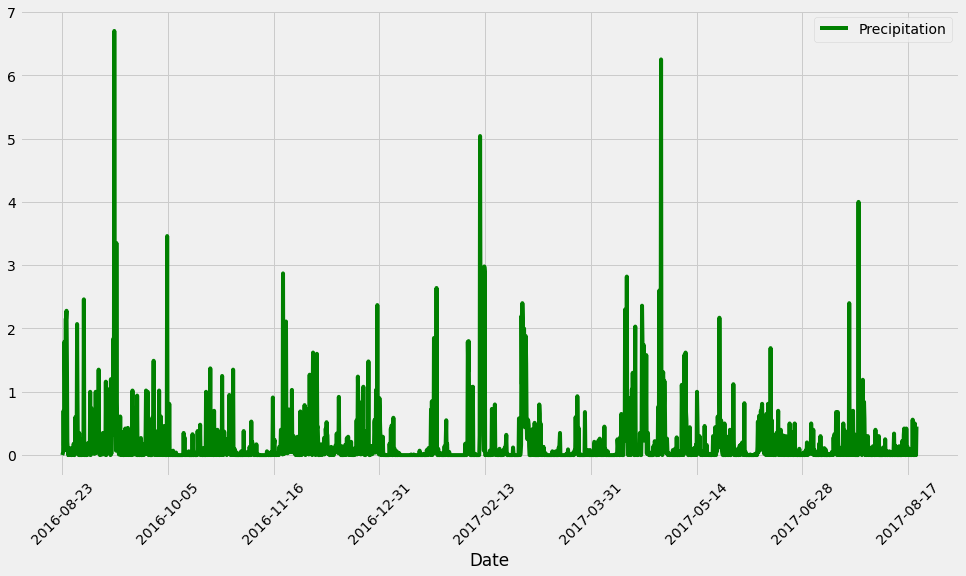

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
precp_data_df.plot(rot=45, color='green', figsize = (15,8))

# Save plot Image
plt.savefig("Images/Precipitation.png")

# Show graph
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precp_data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
Measure_station_count = session.query(Measure.station).distinct().count()
Station_station_count = session.query(Station.station).count()
print(f'Station count in measurement data set: {Measure_station_count} ')
print(f'Station count in station data set: {Station_station_count } ')

Station count in measurement data set: 9 
Station count in station data set: 9 


In [19]:
# List the stations and the counts in descending order.
Station_count = session.query(Measure.station, func.count(Measure.station), Station.name).\
              filter(Measure.station == Station.station).\
              group_by(Measure.station).\
              order_by(func.count(Measure.station).desc()).all()
Station_count

[('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00519397', 2724, 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 2709, 'KANEOHE 838.1, HI US'),
 ('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00517948', 1372, 'PEARL CITY, HI US'),
 ('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US')]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
Max_Station_count = session.query(Measure.station).\
                     group_by(Measure.station).\
                     order_by(func.count(Measure.station).desc()).first()
Max_Station_count[0] 

'USC00519281'

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Min_Temp = session.query(func.min(Measure.tobs)).\
               filter(Measure.station == Max_Station_count[0]).scalar()
Max_Temp = session.query(func.max(Measure.tobs)).\
               filter(Measure.station == Max_Station_count[0]).scalar()
Avg_Temp = session.query(func.avg(Measure.tobs)).\
               filter(Measure.station == Max_Station_count[0]).scalar()

print(f'Minimum Temperature recored for station {Max_Station_count[0]} is {Min_Temp}')
print(f'Maximum Temperature recored for station {Max_Station_count[0]} is {Max_Temp}')
print(f'Average Temperature recored for station {Max_Station_count[0]} is {Avg_Temp}')

Minimum Temperature recored for station USC00519281 is 54.0
Maximum Temperature recored for station USC00519281 is 85.0
Average Temperature recored for station USC00519281 is 71.66378066378067


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

Plot_tobs = session.query(Measure.tobs).\
        filter(Measure.date >= Year_ago_date).\
        filter(Measure.station == Max_Station_count[0] ).all()

Plot_tobs = np.ravel(Plot_tobs)
Plot_tobs

array([77., 77., 80., 80., 75., 73., 78., 77., 78., 80., 80., 78., 78.,
       78., 73., 74., 80., 79., 77., 80., 76., 79., 75., 79., 78., 79.,
       78., 78., 76., 74., 77., 78., 79., 79., 77., 80., 78., 78., 78.,
       77., 79., 79., 79., 79., 75., 76., 73., 72., 71., 77., 79., 78.,
       79., 77., 79., 77., 78., 78., 78., 78., 77., 74., 75., 76., 73.,
       76., 74., 77., 76., 76., 74., 75., 75., 75., 75., 71., 63., 70.,
       68., 67., 77., 74., 77., 76., 76., 75., 76., 75., 73., 75., 73.,
       75., 74., 75., 74., 75., 73., 75., 73., 73., 74., 70., 72., 70.,
       67., 67., 69., 70., 68., 69., 69., 66., 65., 68., 62., 75., 70.,
       69., 76., 76., 74., 73., 71., 74., 74., 72., 71., 72., 74., 69.,
       67., 72., 70., 64., 63., 63., 62., 70., 70., 62., 62., 63., 65.,
       69., 77., 70., 74., 69., 72., 71., 69., 71., 71., 72., 72., 69.,
       70., 66., 65., 69., 68., 68., 68., 59., 60., 70., 73., 75., 64.,
       59., 59., 62., 68., 70., 73., 79., 75., 65., 70., 74., 70

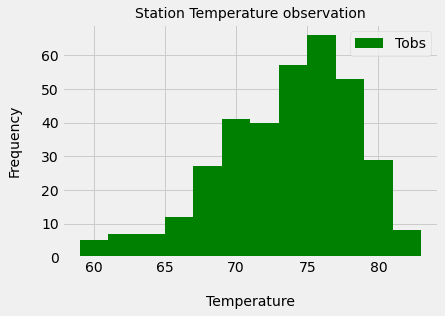

In [23]:
# Plot histogram
plt.hist(Plot_tobs, color="green", bins=12)

# Setup titles and axis labels
plt.xlabel("Temperature", fontsize=14, labelpad=20)
plt.ylabel("Frequency", fontsize=14, labelpad=20)
plt.title("Station Temperature observation", fontsize=14)
plt.legend(['Tobs'])

# Save plot Image
plt.savefig("Images/Station observations.png")

# Show plot
plt.show() 

## Bonus Challenge Assignment

In [24]:
# Temperture Analysis-I
# Identify the average temperature in June at all stations across all available years in the dataset. 

Avg_Temp_June = session.query(Measure.tobs).\
               filter(extract('month', Measure.date)==6).all()
Avg_Temp_June

[(78.0),
 (76.0),
 (78.0),
 (76.0),
 (77.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (77.0),
 (77.0),
 (82.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (76.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (73.0),
 (70.0),
 (76.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (77.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (75.0),
 (76.0),
 (76.0),
 (77.0),
 (78.0),
 (76.0),
 (77.0),
 (75.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (77.0),
 (77.0),
 (76.0),
 (78.0),
 (77.0),
 (76.0),
 (77.0),
 (76.0),
 (76.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (77.0),
 (77.0),
 (76.0),
 (75.0),
 (76.0),
 (76.0),
 (77.0),
 (76.0),
 (73.0),
 (73.0),
 (75.0),
 (77.0),
 (76.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (79.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (76.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (73.0),
 (76.0),
 (77.0),
 (75.0),
 (76.0),
 (74.0),
 

In [25]:
#  Identify the average temperature in December at all stations across all available years in the dataset.

Avg_Temp_Dec = session.query(Measure.tobs).\
               filter(extract('month', Measure.date)==12).all()
Avg_Temp_Dec

[(76.0),
 (74.0),
 (74.0),
 (64.0),
 (64.0),
 (67.0),
 (77.0),
 (66.0),
 (69.0),
 (68.0),
 (68.0),
 (71.0),
 (74.0),
 (67.0),
 (66.0),
 (69.0),
 (71.0),
 (70.0),
 (70.0),
 (74.0),
 (74.0),
 (71.0),
 (75.0),
 (75.0),
 (72.0),
 (69.0),
 (68.0),
 (73.0),
 (74.0),
 (73.0),
 (73.0),
 (73.0),
 (73.0),
 (71.0),
 (73.0),
 (73.0),
 (77.0),
 (72.0),
 (71.0),
 (73.0),
 (70.0),
 (73.0),
 (69.0),
 (74.0),
 (72.0),
 (71.0),
 (72.0),
 (72.0),
 (70.0),
 (73.0),
 (73.0),
 (72.0),
 (73.0),
 (73.0),
 (72.0),
 (63.0),
 (65.0),
 (71.0),
 (76.0),
 (70.0),
 (76.0),
 (69.0),
 (69.0),
 (69.0),
 (74.0),
 (76.0),
 (74.0),
 (73.0),
 (73.0),
 (74.0),
 (73.0),
 (73.0),
 (73.0),
 (74.0),
 (74.0),
 (71.0),
 (73.0),
 (72.0),
 (64.0),
 (66.0),
 (73.0),
 (72.0),
 (65.0),
 (64.0),
 (69.0),
 (68.0),
 (77.0),
 (71.0),
 (71.0),
 (69.0),
 (68.0),
 (68.0),
 (69.0),
 (70.0),
 (72.0),
 (76.0),
 (75.0),
 (69.0),
 (71.0),
 (71.0),
 (71.0),
 (68.0),
 (65.0),
 (70.0),
 (69.0),
 (69.0),
 (71.0),
 (67.0),
 (73.0),
 (74.0),
 (73.0),
 

In [26]:
June_temp_df = pd.DataFrame(Avg_Temp_June, columns = ['Temperature'])
June_temp_df['Month'] = 'June'

Dec_temp_df = pd.DataFrame(Avg_Temp_Dec, columns = ['Temperature'])
Dec_temp_df['Month'] = 'December'

Avg_temp_df = pd.concat([June_temp_df,Dec_temp_df])
Avg_temp_df = Avg_temp_df.set_index('Month')
Avg_temp_df

,Temperature
Month,
June,78.0
June,76.0
June,78.0
June,76.0
June,77.0
...,...
December,71.0
December,71.0
December,69.0


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

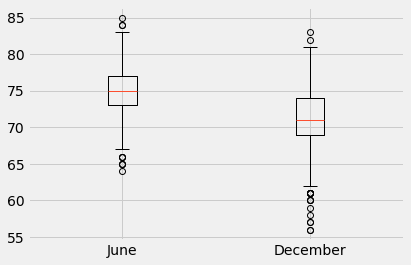

In [27]:
#  Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?
 
box_data = [June_temp_df["Temperature"],Dec_temp_df["Temperature"]]
plt.boxplot(box_data,labels=['June', 'December'])
stats.ttest_ind(June_temp_df["Temperature"], Dec_temp_df["Temperature"])

In [28]:
# Analysis from above:
# from the above box plot we can see difference in means of temperatures is significant.
# We will perform unpaired t-test for this analysis as June temperature is not dependent on December temperature.

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
        filter(Measure.date >= start_date).filter(Measure.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
Trip_start_date = '2016-07-01'
Trip_end_date = '2016-07-10'

Last_date_st = dt.datetime.strptime(Trip_start_date, "%Y-%m-%d")
year_st = Last_date_st.year
month_st = Last_date_st.month
day_st = Last_date_st.day

Last_date_end = dt.datetime.strptime(Trip_end_date, "%Y-%m-%d")
year_ed = Last_date_end.year
month_ed = Last_date_end.month
day_ed = Last_date_end.day

Trip_start_Year_ago_date = dt.date(year_st,month_st,day_st) - dt.timedelta(days=366)
Trip_end_Year_ago_date = dt.date(year_ed,month_ed,day_ed) - dt.timedelta(days=366)

Trip_start_Year_ago_date , Trip_end_Year_ago_date

(datetime.date(2015, 7, 1), datetime.date(2015, 7, 10))

In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
        filter(Measure.date >= start_date).filter(Measure.date <= end_date).all()

# function usage example
tmin, tave, tmax = calc_temps(Trip_start_Year_ago_date, Trip_end_Year_ago_date)[0]
print(tmin, tmax, tave)

67.0 83.0 77.125


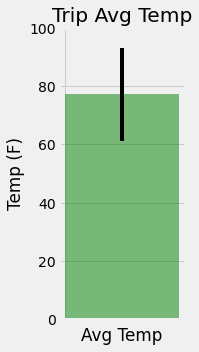

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,5))
plt.bar(x=[""],height=[tave],yerr=tmax-tmin,color='g',alpha=.5,align='edge')
plt.ylim(0,100)
plt.xlabel("Avg Temp")
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
# Save plot Image
plt.savefig("Images/Trip Avg temp.png")

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Trip_Precp_data = session.query(Measure.station, Station.name, Station.latitude, Station.longitude, 
                                Station.elevation, func.sum(Measure.prcp)).\
                  filter(Measure.date >= Trip_start_Year_ago_date , Measure.date <= Trip_end_Year_ago_date).\
                  filter(Measure.station == Station.station).\
                  group_by(Measure.station).\
                  order_by(func.sum(Measure.prcp).desc()).all()

Trip_Precp_data

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.79),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.1400000000000001),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.56),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.1),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.0)]

In [34]:
Trip_Precp_df = pd.DataFrame(Trip_Precp_data, columns = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Total_recp'])
Trip_Precp_df

,Station,Name,Latitude,Longitude,Elevation,Total_recp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.79
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.14
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.56
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.10
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.00
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00


In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measure.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [49]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
Trip_start_date = '2016-07-01'
Trip_end_date = '2016-07-10'
 
# Use the start and end date to create a range of dates
start = dt.datetime.strptime(Trip_start_date,"%Y-%m-%d")
end = dt.datetime.strptime(Trip_end_date,"%Y-%m-%d")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

# Define lists for Dates and Normals
Date = []
Normals = []

# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_generated:
    dates_string = dt.datetime.strftime(date,"%m-%d")
    Date.append(dates_string)
    Normals.append(daily_normals(dates_string)[0])
#   print(dt.datetime.strftime(date,"%m-%d"))  
print(Date, Normals)    

['07-01', '07-02', '07-03', '07-04', '07-05', '07-06', '07-07', '07-08', '07-09'] [(67.0, 74.77777777777777, 81.0), (68.0, 75.40384615384616, 82.0), (68.0, 75.32075471698113, 87.0), (70.0, 76.57142857142857, 81.0), (66.0, 75.0, 81.0), (69.0, 75.0, 81.0), (69.0, 74.91071428571429, 82.0), (69.0, 76.08333333333333, 83.0), (68.0, 76.19298245614036, 83.0)]


In [50]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Daily_Normal_df = pd.DataFrame(Normals, columns = ['Normal_Min', 'Normal_Avg', 'Normal_Max'])
Daily_Normal_df['Dates'] = Date 
Daily_Normal_df = Daily_Normal_df.set_index('Dates')
Daily_Normal_df

,Normal_Min,Normal_Avg,Normal_Max
Dates,,,
07-01,67.0,74.777778,81.0
07-02,68.0,75.403846,82.0
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0


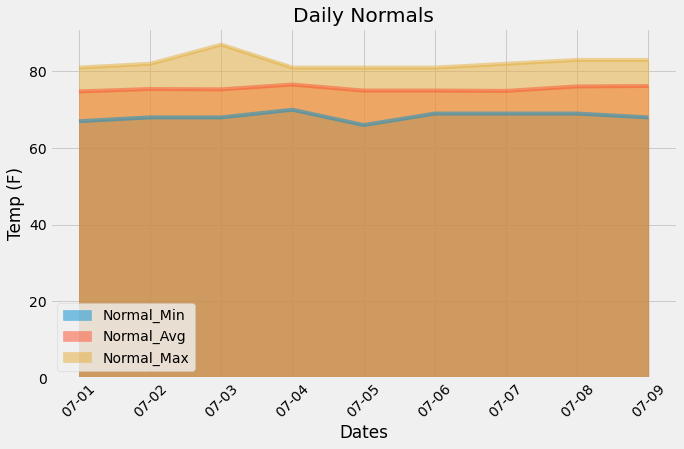

In [51]:
# Plot the daily normals as an area plot with `stacked=False`
Daily_Normal_df.plot.area(stacked=False, figsize=(10,6), fontsize=14, rot=45)
plt.ylabel("Temp (F)")
plt.title("Daily Normals")
# Save plot Image
plt.savefig("Images/Daily Normals.png")